In [ ]:
import numpy as np
import os
import pandas as pd 

### Step 1 we calculate all the features we need 

In [4]:
input_file_path='T:\\TOSHITH\\PROGRAMMING\\music_genere_classification\\genres_processed'
output_file_path ="T:\TOSHITH\PROGRAMMING\music_genere_classification"

<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
C:\Users\toshi\AppData\Local\Temp\ipykernel_41252\1882625217.py:2: SyntaxWarning: invalid escape sequence '\T'
  output_file_path ="T:\TOSHITH\PROGRAMMING\music_genere_classification"


In [3]:
# List of feature columns 
feature_columns = [
    "Amplitude_Envelope", "RMS_Energy", "Zero_Crossing_Rate", "SFOSE",
    "MFCC", "Delta_MFCC", "Delta2_MFCC",
    "Spectral_Centroid", "Spectral_Bandwidth", "Band_Energy_Ratio"
]

# List of statistics to compute
statistics = [
    "mean", "median", "std", "var", "min", "max",
    "range", "q1", "q3", "iqr", "skew", "kurtosis"
]

# Prepare column names for the output table
output_columns = []
for feature in feature_columns:
    for stat in statistics:
        output_columns.append(f"{feature}_{stat}")
output_columns.append("Genre")

# Initialize the output DataFrame
output_df = pd.DataFrame(columns=output_columns)

# Walk through each genre subfolder
for genre in os.listdir(input_file_path):
    genre_path = os.path.join(input_file_path, genre)
    if not os.path.isdir(genre_path):
        continue
    # Process each CSV file in the genre subfolder
    for csv_file in os.listdir(genre_path):
        if not csv_file.endswith(".csv"):
            continue

        csv_path = os.path.join(genre_path, csv_file)
        df = pd.read_csv(csv_path)

        # Initialize a row for this file
        row = {}

        # Compute statistics for each feature
        for feature in feature_columns:
            data = df[feature]
            row[f"{feature}_mean"] = data.mean()
            row[f"{feature}_median"] = data.median()
            row[f"{feature}_std"] = data.std()
            row[f"{feature}_var"] = data.var()
            row[f"{feature}_min"] = data.min()
            row[f"{feature}_max"] = data.max()
            row[f"{feature}_range"] = data.max() - data.min()
            q1, q3 = data.quantile([0.25, 0.75])
            row[f"{feature}_q1"] = q1
            row[f"{feature}_q3"] = q3
            row[f"{feature}_iqr"] = q3 - q1
            row[f"{feature}_skew"] = data.skew()
            row[f"{feature}_kurtosis"] = data.kurtosis()

        # Add the genre label
        row["Genre"] = genre

        # Append the row to the output DataFrame
        output_df = pd.concat([output_df, pd.DataFrame([row])], ignore_index=True)

# Save the output table
output_df.to_csv(os.path.join(output_file_path, "final_ML_data.csv"), index=False)


C:\Users\toshi\AppData\Local\Temp\ipykernel_4084\232801724.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat([output_df, pd.DataFrame([row])], ignore_index=True)


### Random Forest classifier 

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sn 
import matplotlib.pyplot as plt

In [13]:
data = pd.read_csv(os.path.join(output_file_path, "final_ML_data.csv"))

# Features (all columns except 'Genre')
X = data.drop(columns=['Genre'])
# Target (genre labels)
y = data['Genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(len(X_train))
rf = RandomForestClassifier(n_estimators=120)
rf.fit(X_train, y_train)
rf.score(X_test,y_test)

699


0.6533333333333333

Text(50.722222222222214, 0.5, 'actual')

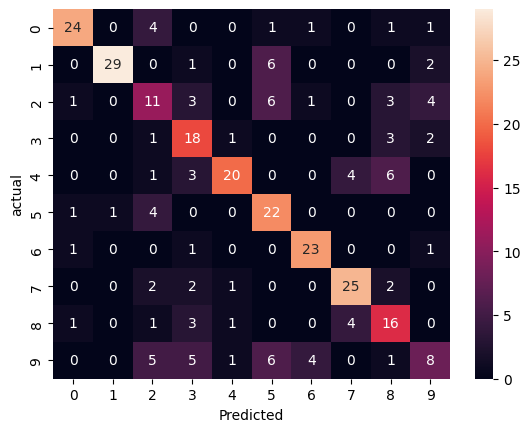

In [14]:
y_predicted=rf.predict(X_test)
cm=confusion_matrix(y_test,y_predicted)

plt.figure()

sn.heatmap(cm,annot=True)
plt.xlabel("Predicted")
plt.ylabel("actual")

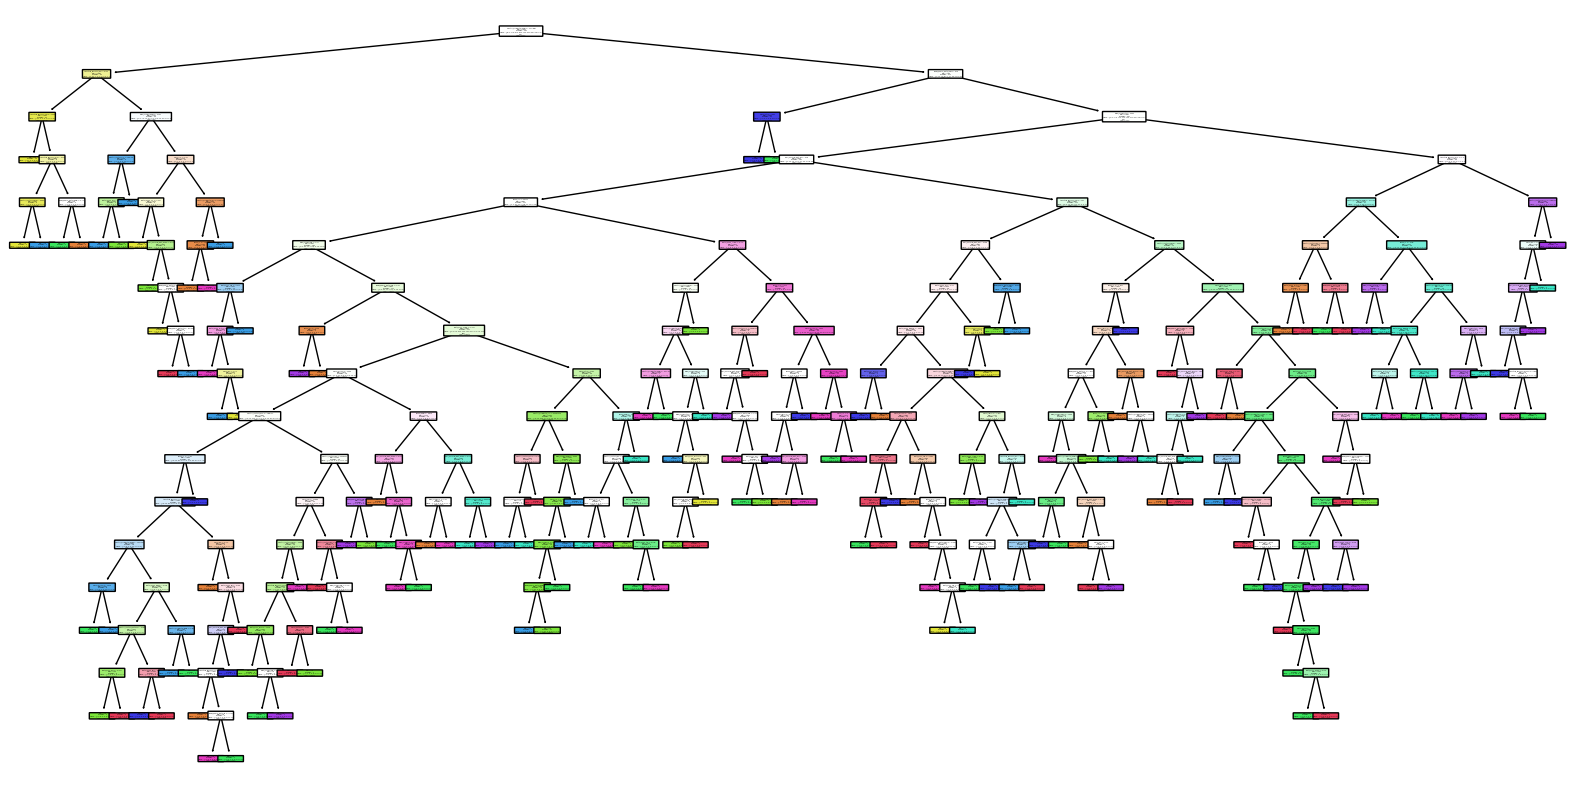

In [15]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Visualize the first tree in the random forest
plt.figure(figsize=(20,10))
plot_tree(rf.estimators_[0], filled=True, feature_names=X_train.columns, class_names=rf.classes_, rounded=True)
plt.show()

### XGBoost classifier 

In [83]:
import pandas as pd

statistics_df = pd.read_csv(os.path.join(output_file_path, "final_ML_data.csv"))
statistics_df=pd.read_csv(r"T:\TOSHITH\PROGRAMMING\music_genere_classification\\features_30_sec.csv")

features_to_drop=['filename', 'length','label']
X = statistics_df.drop(features_to_drop, axis=1)
y = statistics_df['label']

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [84]:
from sklearn.model_selection import train_test_split

# First, split into train (80%) and temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Then, split temp into validation (50%) and test (50%)
# This gives 80% train, 10% validation, 10% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [85]:
from xgboost import XGBClassifier

# Determine number of unique classes
num_classes = len(statistics_df['label'].unique())
'''
model = XGBClassifier(
    objective='multi:softprob',
    num_class=num_classes,
    n_estimators=130,
    max_depth=6,                   # Reduced from 200
    learning_rate=0.1,             # Increased from 0.01
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,            # Added
    gamma=0,                       # Added
    reg_alpha=0,                   # Added
    reg_lambda=1,                  # Added
    random_state=42
)'''

model_feat = XGBClassifier(
    objective='multi:softprob',
    num_class=num_classes,
    n_estimators=500,              # Increased for lower learning_rate
    max_depth=3,                   # Decreased
    learning_rate=0.01,            # Decreased
    subsample=0.5,                 # Decreased
    colsample_bytree=0.5,          # Decreased
    min_child_weight=5,            # Increased
    gamma=2,                       # Increased
    reg_alpha=0.5,                 # Increased
    reg_lambda=2,                  # Increased
    early_stopping_rounds=10,
    random_state=42
)
model_feat.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],  # Use validation set for early stopping
    verbose=True
)

[0]	validation_0-mlogloss:2.29119
[1]	validation_0-mlogloss:2.28213
[2]	validation_0-mlogloss:2.27225


[3]	validation_0-mlogloss:2.26278
[4]	validation_0-mlogloss:2.25421
[5]	validation_0-mlogloss:2.24453
[6]	validation_0-mlogloss:2.23563
[7]	validation_0-mlogloss:2.22524
[8]	validation_0-mlogloss:2.21648
[9]	validation_0-mlogloss:2.20755
[10]	validation_0-mlogloss:2.19905
[11]	validation_0-mlogloss:2.19085
[12]	validation_0-mlogloss:2.18295
[13]	validation_0-mlogloss:2.17454
[14]	validation_0-mlogloss:2.16583
[15]	validation_0-mlogloss:2.15687
[16]	validation_0-mlogloss:2.15011
[17]	validation_0-mlogloss:2.14199
[18]	validation_0-mlogloss:2.13379
[19]	validation_0-mlogloss:2.12744
[20]	validation_0-mlogloss:2.11969
[21]	validation_0-mlogloss:2.11056
[22]	validation_0-mlogloss:2.10305
[23]	validation_0-mlogloss:2.09542
[24]	validation_0-mlogloss:2.08807
[25]	validation_0-mlogloss:2.08006
[26]	validation_0-mlogloss:2.07269
[27]	validation_0-mlogloss:2.06592
[28]	validation_0-mlogloss:2.05873
[29]	validation_0-mlogloss:2.05202
[30]	validation_0-mlogloss:2.04552
[31]	validation_0-mlogloss:

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_class=10, ...)

In [86]:
#dimentionality reduction 
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(model_feat, threshold='mean', prefit=True)
X_train_selected = selector.transform(X_train)
X_val_selected = selector.transform(X_val)    # Transform validation set
X_test_selected = selector.transform(X_test)  # Transform test set
X_selected = selector.transform(X)

model = XGBClassifier(
    objective='multi:softprob',
    num_class=num_classes,
    n_estimators=500,              # Increased for lower learning_rate
    max_depth=3,                   # Decreased
    learning_rate=0.01,            # Decreased
    subsample=0.5,                 # Decreased
    colsample_bytree=0.5,          # Decreased
    min_child_weight=5,            # Increased
    gamma=2,                       # Increased
    reg_alpha=0.5,                 # Increased
    reg_lambda=2,                  # Increased
    random_state=42
)
model.fit(
    X_train_selected, y_train,
    eval_set=[(X_val_selected, y_val)],  # Early stopping on validation set
    verbose=True
)

[0]	validation_0-mlogloss:2.29197
[1]	validation_0-mlogloss:2.28434
[2]	validation_0-mlogloss:2.27408
[3]	validation_0-mlogloss:2.26595
[4]	validation_0-mlogloss:2.25878
[5]	validation_0-mlogloss:2.24964
[6]	validation_0-mlogloss:2.24086
[7]	validation_0-mlogloss:2.22924
[8]	validation_0-mlogloss:2.21910
[9]	validation_0-mlogloss:2.21111
[10]	validation_0-mlogloss:2.20286
[11]	validation_0-mlogloss:2.19399
[12]	validation_0-mlogloss:2.18553
[13]	validation_0-mlogloss:2.17745
[14]	validation_0-mlogloss:2.16929
[15]	validation_0-mlogloss:2.16190
[16]	validation_0-mlogloss:2.15376
[17]	validation_0-mlogloss:2.14530
[18]	validation_0-mlogloss:2.13716
[19]	validation_0-mlogloss:2.12896
[20]	validation_0-mlogloss:2.12280
[21]	validation_0-mlogloss:2.11357
[22]	validation_0-mlogloss:2.10525
[23]	validation_0-mlogloss:2.09762
[24]	validation_0-mlogloss:2.08952
[25]	validation_0-mlogloss:2.08113
[26]	validation_0-mlogloss:2.07385
[27]	validation_0-mlogloss:2.06684
[28]	validation_0-mlogloss:2.0

c:\Users\toshi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\toshi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\toshi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\toshi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


[60]	validation_0-mlogloss:1.86119
[61]	validation_0-mlogloss:1.85691
[62]	validation_0-mlogloss:1.85159
[63]	validation_0-mlogloss:1.84637
[64]	validation_0-mlogloss:1.84206
[65]	validation_0-mlogloss:1.83671
[66]	validation_0-mlogloss:1.83120
[67]	validation_0-mlogloss:1.82624
[68]	validation_0-mlogloss:1.82087
[69]	validation_0-mlogloss:1.81644
[70]	validation_0-mlogloss:1.81116
[71]	validation_0-mlogloss:1.80652
[72]	validation_0-mlogloss:1.80287
[73]	validation_0-mlogloss:1.79738
[74]	validation_0-mlogloss:1.79186
[75]	validation_0-mlogloss:1.78620
[76]	validation_0-mlogloss:1.78106
[77]	validation_0-mlogloss:1.77724
[78]	validation_0-mlogloss:1.77283
[79]	validation_0-mlogloss:1.76766
[80]	validation_0-mlogloss:1.76209
[81]	validation_0-mlogloss:1.75714
[82]	validation_0-mlogloss:1.75208
[83]	validation_0-mlogloss:1.74828
[84]	validation_0-mlogloss:1.74456
[85]	validation_0-mlogloss:1.74075
[86]	validation_0-mlogloss:1.73712
[87]	validation_0-mlogloss:1.73371
[88]	validation_0-ml

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_class=10, ...)

In [87]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred, target_names=list(le.classes_)))

Accuracy: 0.57
              precision    recall  f1-score   support

       blues       0.57      0.62      0.59        13
   classical       0.86      1.00      0.92         6
     country       0.57      0.50      0.53        16
       disco       0.70      0.54      0.61        13
      hiphop       0.27      0.50      0.35         6
        jazz       0.71      0.83      0.77         6
       metal       0.69      0.92      0.79        12
         pop       0.80      0.50      0.62         8
      reggae       0.30      0.27      0.29        11
        rock       0.33      0.22      0.27         9

    accuracy                           0.57       100
   macro avg       0.58      0.59      0.57       100
weighted avg       0.58      0.57      0.56       100



In [88]:
#checking for over and under fit 
# Make predictions on training data
y_train_pred = model.predict(X_train_selected)

# Calculate training metrics
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred, target_names=list(le.classes_)))

# Make predictions on test data (as you already did)
y_test_pred = model.predict(X_test_selected)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, target_names=list(le.classes_)))

Training Accuracy: 0.7925
              precision    recall  f1-score   support

       blues       0.82      0.78      0.79        80
   classical       0.92      0.92      0.92        87
     country       0.72      0.71      0.72        73
       disco       0.73      0.75      0.74        79
      hiphop       0.80      0.78      0.79        85
        jazz       0.82      0.85      0.84        78
       metal       0.87      0.88      0.87        75
         pop       0.90      0.89      0.89        87
      reggae       0.72      0.73      0.72        77
        rock       0.62      0.63      0.62        79

    accuracy                           0.79       800
   macro avg       0.79      0.79      0.79       800
weighted avg       0.79      0.79      0.79       800

Test Accuracy: 0.57
              precision    recall  f1-score   support

       blues       0.57      0.62      0.59        13
   classical       0.86      1.00      0.92         6
     country       0.57      0.5

In [89]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model, X_selected, y_encoded, cv=5, return_train_score=True)
print("Train scores:", cv_results['train_score'])
print("Test scores:", cv_results['test_score'])

Train scores: [0.8275 0.805  0.805  0.785  0.805 ]
Test scores: [0.53 0.68 0.49 0.6  0.44]


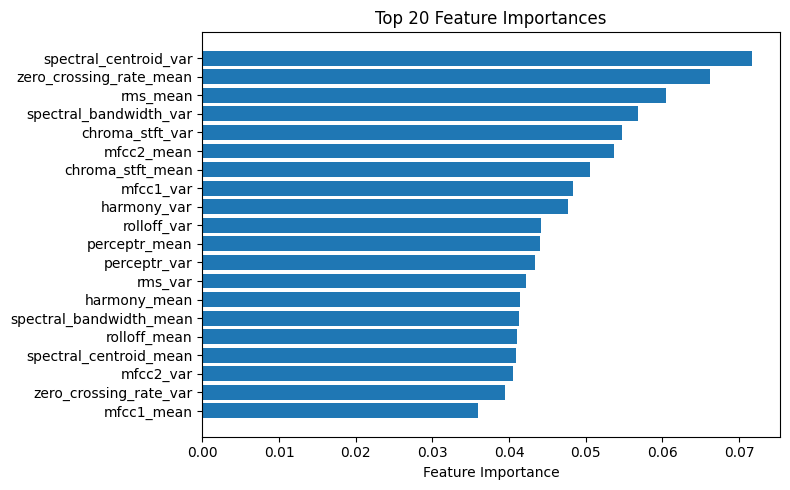

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances and names
importances = model.feature_importances_
feature_names = X.columns

# Sort features by importance
sorted_idx = np.argsort(importances)[::-1]

# Select top N features
top_n = 20
plt.figure(figsize=(8, 5))
plt.barh(range(top_n), importances[sorted_idx][:top_n], align='center')
plt.yticks(range(top_n), feature_names[sorted_idx][:top_n])
plt.xlabel("Feature Importance")
plt.title("Top 20 Feature Importances")
plt.gca().invert_yaxis()  # Most important at top
plt.tight_layout()
plt.show()